#Names
##1) Morad Khoury
##2) Ram Khoury

In this exercise we based our implementation on:

https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html

we set the hyperparameters using trial and error with help from the tutorial link shown above,
we implemented a DQN agent that contains: neural network that predicts the q-values for a given observation,
an experience replay buffer where all transitions are added and
a target Q-network that is formed by copying the weights of the main Q-nework.

we trained the agent on 400-450 episodes with max number of steps until termination being 200.

The challenge we encountered was Training RL agents because it can be a noisy process, so restarting training can produce better results if convergence is not observed.

What helped us beating this challenge was:

1) Finding the optimal range of hyperparameter values used.

2) Using a decaying epsilon to help with exploration and a correct decaying value.

3) Having the target network be updated at every step with a soft update controlled by the hyperparameter TAU, which was previously defined, instead of periodically updating the target_network weights.

After implementing these 3 steps, the results were significantly smoother with better stability.

# Deep Q-Network for Cart-Pole.

In this assignment you are required to implement a Deep Q-Network agent, for the Cart-Pole problem.

You need to submit your code, along with a plot of the rewards during training, and a video of an episode with the trained agent.


__Frameworks__ - we'll accept this homework in any deep learning framework. This particular notebook was designed for PyTorch, but you'll find it easy to adapt it to almost any Python-based deep learning framework.

In [ ]:
!pip install stable-baselines3 gym==0.22.0
!pip install pyglet==1.5.27
!pip install pyvirtualdisplay
!pip install numpy matplotlib gym torch torchvision


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.7/181.7 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 631.1/631.1 kB 9.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 59.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 64.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 91.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
import torch
# device config
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
print('device: ', device)

device:  cuda


In [ ]:
import os
import random
import numpy as np
import torch
import gym
import numpy as np
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display

if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !apt-get -qq install -y xvfb
    os.environ['DISPLAY'] = ':1'

display = Display(visible=0, size=(400, 300))
display.start()


Selecting previously unselected package libfontenc1:amd64.
(Reading database ... 121753 files and directories currently installed.)
Preparing to unpack .../0-libfontenc1_1%3a1.1.4-1build3_amd64.deb ...
Unpacking libfontenc1:amd64 (1:1.1.4-1build3) ...
Selecting previously unselected package libxfont2:amd64.
Preparing to unpack .../1-libxfont2_1%3a2.0.5-1build1_amd64.deb ...
Unpacking libxfont2:amd64 (1:2.0.5-1build1) ...
Selecting previously unselected package libxkbfile1:amd64.
Preparing to unpack .../2-libxkbfile1_1%3a1.1.0-1build3_amd64.deb ...
Unpacking libxkbfile1:amd64 (1:1.1.0-1build3) ...
Selecting previously unselected package x11-xkb-utils.
Preparing to unpack .../3-x11-xkb-utils_7.7+5build4_amd64.deb ...
Unpacking x11-xkb-utils (7.7+5build4) ...
Selecting previously unselected package xfonts-encodings.
Preparing to unpack .../4-xfonts-encodings_1%3a1.0.5-0ubuntu2_all.deb ...
Unpacking xfonts-encodings (1:1.0.5-0ubuntu2) ...
Selecting previously unselected package xfonts-util

## Cart Pole

In this environment a pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The pendulum is placed upright on the cart and the goal is to balance the pole by applying forces in the left and right direction on the cart.

The observation consists of the cart position, cart velocity, pole angle and pole angular velocity.

There are 2 actions corresponding to moving the cart to the left and to the right.

See full description [here](https://www.gymlibrary.dev/environments/classic_control/cart_pole/).



In [ ]:
ENV_NAME = "CartPole-v0"

def make_env(seed=None):
    # some envs are wrapped with a time limit wrapper by default
    env = gym.make(ENV_NAME).unwrapped
    if seed is not None:
        env.seed(seed)
    return env

/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:505: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1` with the environment ID `CartPole-v1`.
  logger.warn(


observation dim (4,) number of actions 2


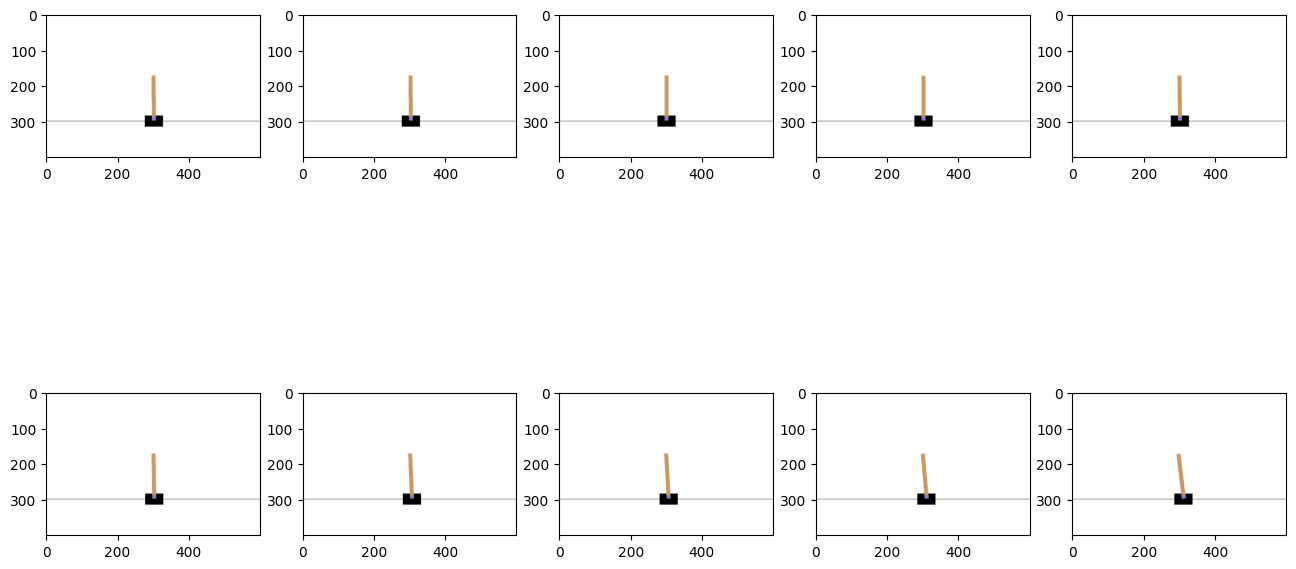

In [ ]:
env = gym.make(ENV_NAME)
obs = env.reset()


n_actions = env.action_space.n
obs_dim = obs.shape
print("observation dim", obs_dim, "number of actions", n_actions)

n_cols = 5
n_rows = 2
fig = plt.figure(figsize=(16, 9))

for row in range(n_rows):
    for col in range(n_cols):
        ax = fig.add_subplot(n_rows, n_cols, row * n_cols + col + 1)
        ax.imshow(env.render('rgb_array'))
        env.step(env.action_space.sample())
plt.show()

## Random Agent

Here we implement a random agent to use in the 'evaluate' function, that runs the agent through multiple epsiodes.

In [ ]:
class RandomAgent():
    def __init__(self, n_actions):
        self.n_actions = n_actions


    def get_qvalues(self, states):
        return np.random.normal(size=(1,self.n_actions,))

    def sample_actions(self, qvalues):
        return np.random.randint(self.n_actions, size=(1,))

In [ ]:
def evaluate(env, agent, n_games=1, greedy=False, t_max=10000):
    """ Plays n_games full games. If greedy, picks actions as argmax(qvalues). Returns mean reward. """
    rewards = []
    for _ in range(n_games):
        s = env.reset()
        reward = 0
        for _ in range(t_max):
            qvalues = agent.get_qvalues([s])
            action = qvalues.argmax(axis=-1)[0] if greedy else agent.sample_actions(qvalues)[0]
            s, r, done, _ = env.step(action)
            reward += r
            if done:
              break

        rewards.append(reward)
    return np.mean(rewards)

agent = RandomAgent(n_actions)
mean_reward = evaluate(env, agent, greedy=True, n_games=5)

## Video generation

In [ ]:
# run sessions

import gym.wrappers
import sys
from pathlib import Path
from base64 import b64encode
from IPython.display import HTML

n_games = 1 # how many games to record

with gym.wrappers.Monitor(make_env(), directory="videos", force=True) as env_monitor:
    env_monitor.reset()
    sessions = [evaluate(env_monitor, agent, n_games=1000, greedy=False) for _ in range(10)]


In [ ]:
# show video

video_paths = sorted([s for s in Path('videos').iterdir() if s.suffix == '.mp4'])
video_path = video_paths[-1]  # You can also try other indices (if n_games>1)

if 'google.colab' in sys.modules:
    # https://stackoverflow.com/a/57378660/1214547
    with video_path.open('rb') as fp:
        mp4 = fp.read()
    data_url = 'data:video/mp4;base64,' + b64encode(mp4).decode()
else:
    data_url = str(video_path)

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(data_url))

## Assignment

Implement a DQN agent that contains:
1. A neural network that predicts the q-values for a given observation.
2. An experience replay buffer where all transitions are added.
3. A target Q-network that is formed by periodically copying the weights of the main Q-nework.

You will also need to implement the training loop, and submit a figure showing the reward as a function of the training step, and a video showing an episode with the trained agent.

#Imports

In [ ]:
import random
from collections import deque
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import gym
import cv2
import matplotlib.pyplot as plt
import gym.wrappers
import sys
from pathlib import Path
from base64 import b64encode
from IPython.display import HTML
import os
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
from gym.wrappers import Monitor
import math


from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# Define a simple neural network for Q-values
class QNetwork(nn.Module):
    def __init__(self, obs_dim, n_actions):
        super(QNetwork, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(obs_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, n_actions)
        )

    def forward(self, x):
        return self.fc(x)

# Experience Replay Buffer
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        states, actions, rewards, next_states, dones = zip(*random.sample(self.buffer, batch_size))
        return np.array(states), np.array(actions), np.array(rewards), np.array(next_states), np.array(dones)

    def __len__(self):
        return len(self.buffer)

EPS_START = 0.9
EPS_END = 0.01
EPS_DECAY = 1000

# DQN Agent
class DQNAgent:
    def __init__(self, obs_dim, n_actions,tau=0.005, gamma=0.99, epsilon=1.0, lr=1e-4, memory_size=10000, batch_size=128):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.obs_dim = obs_dim
        self.n_actions = n_actions
        self.gamma = gamma
        self.epsilon = epsilon
        self.lr = lr
        self.batch_size = batch_size
        self.memory = ReplayBuffer(memory_size)
        self.tau = tau
        self.q_network = QNetwork(obs_dim, n_actions).to(self.device)
        self.target_network = QNetwork(obs_dim, n_actions).to(self.device)
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.target_network.eval()

        self.optimizer = optim.AdamW(self.q_network.parameters(), lr=lr, amsgrad=True)
        self.criterion = nn.SmoothL1Loss()
        self.step = 0

    def select_action(self, state):
        if random.random() < self.epsilon:
            return random.randint(0, self.n_actions - 1)
        else:
            with torch.no_grad():
                state = torch.tensor(state, dtype=torch.float32).to(self.device)
                q_values = self.q_network(state.unsqueeze(0))
                return q_values.max(1)[1].item()

    def update(self):
        if len(self.memory) < self.batch_size:
            return
        states, actions, rewards, next_states, dones = self.memory.sample(self.batch_size)

        states = torch.tensor(states, dtype=torch.float32).to(self.device)
        actions = torch.tensor(actions, dtype=torch.long).to(self.device)
        rewards = torch.tensor(rewards, dtype=torch.float32).to(self.device)
        next_states = torch.tensor(next_states, dtype=torch.float32).to(self.device)
        dones = torch.tensor(dones, dtype=torch.float32).to(self.device)

        current_q_values = self.q_network(states).gather(1, actions.unsqueeze(1)).squeeze(1)
        next_q_values = self.target_network(next_states).max(1)[0]
        target_q_values = rewards + (1 - dones) * self.gamma * next_q_values

        loss = self.criterion(current_q_values, target_q_values.detach())
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_value_(self.q_network.parameters(), 100)
        self.optimizer.step()

        # # Update epsilon
        self.epsilon = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * self.step / EPS_DECAY)

        self.step += 1
    def store_transition(self, state, action, reward, next_state, done):
        self.memory.push(state, action, reward, next_state, done)

    def get_qvalues(self, states):
        with torch.no_grad():
            states = torch.tensor(states, dtype=torch.float32).to(self.device)
            q_values = self.q_network(states)
            return q_values.cpu().numpy()

    def sample_actions(self, qvalues):
        return qvalues.argmax(axis=-1)




#Training Function

Episode 5, Reward: 42.0, Epsilon: 0.8911443520367597
Episode 10, Reward: 26.0, Epsilon: 0.7608616867707815
Episode 15, Reward: 14.0, Epsilon: 0.6887286818005082
Episode 20, Reward: 11.0, Epsilon: 0.6241391079873222
Episode 25, Reward: 8.0, Epsilon: 0.5883744305895271
Episode 30, Reward: 10.0, Epsilon: 0.544975773517688
Episode 35, Reward: 18.0, Epsilon: 0.51432528303018
Episode 40, Reward: 9.0, Epsilon: 0.4807002420900574
Episode 45, Reward: 10.0, Epsilon: 0.4519609203743545
Episode 50, Reward: 14.0, Epsilon: 0.42622312003881924
Episode 55, Reward: 13.0, Epsilon: 0.3996393091000941
Episode 60, Reward: 12.0, Epsilon: 0.376948482200739
Episode 65, Reward: 13.0, Epsilon: 0.3587033158196101
Episode 70, Reward: 13.0, Epsilon: 0.3380681833100428
Episode 75, Reward: 14.0, Epsilon: 0.3180374796440149
Episode 80, Reward: 12.0, Epsilon: 0.2998088195711187
Episode 85, Reward: 14.0, Epsilon: 0.2812989807444452
Episode 90, Reward: 12.0, Epsilon: 0.2654997580626745
Episode 95, Reward: 13.0, Epsilon:

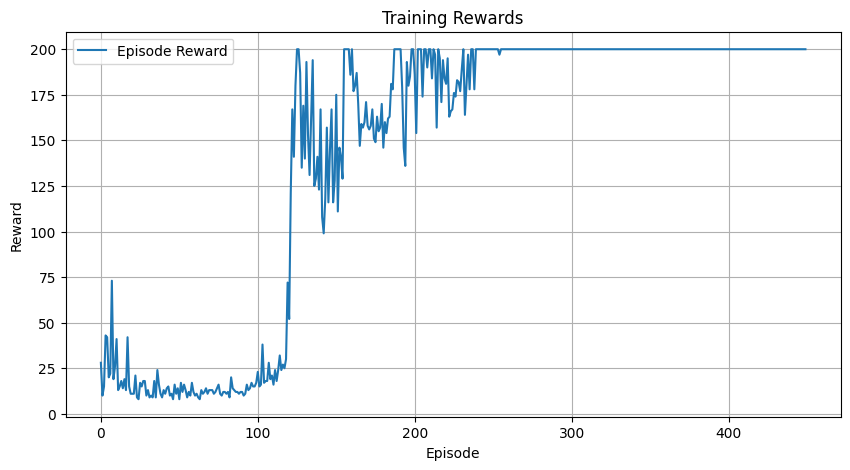

In [ ]:
# Training Loop
def train(env_name="CartPole-v1", num_episodes=500, max_steps=200, batch_size=128):
    env = gym.make(env_name)
    obs_dim = env.observation_space.shape[0]
    n_actions = env.action_space.n
    agent = DQNAgent(obs_dim, n_actions, batch_size=batch_size)
    rewards = []
    for episode in range(1, num_episodes+1):
        state = env.reset()
        total_reward = 0
        for step in range(max_steps):
            action = agent.select_action(state)
            next_state, reward, done, _ = env.step(action)
            agent.store_transition(state, action, reward, next_state, done)
            agent.update()
            state = next_state
            total_reward += reward

            # Soft update of the target network's weights
            # θ′ ← τ θ + (1 −τ )θ′
            target_net_state_dict = agent.target_network.state_dict()
            policy_net_state_dict = agent.q_network.state_dict()
            for key in policy_net_state_dict:
                target_net_state_dict[key] = policy_net_state_dict[key]*agent.tau + target_net_state_dict[key]*(1-agent.tau)
            agent.target_network.load_state_dict(target_net_state_dict)

            if done:
                break
        rewards.append(total_reward)
        if episode % 5 == 0:
            print(f"Episode {episode}, Reward: {total_reward}, Epsilon: {agent.epsilon}")

    env.close()
    return rewards, agent

# Plotting function
def plot_rewards(rewards):
    plt.figure(figsize=(10, 5))
    plt.plot(rewards, label='Episode Reward')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title('Training Rewards')
    plt.legend()
    plt.grid(True)
    plt.show()

# Main
num_episodes = 450
rewards, agent = train(env_name="CartPole-v1", num_episodes=num_episodes, max_steps=200, batch_size=128)
plot_rewards(rewards)

if os.path.exists("/content/gdrive/My Drive/Colab_RL"):
    torch.save(agent, r"/content/gdrive/My Drive/Colab_RL/agent")
    torch.save(rewards, r"/content/gdrive/My Drive/Colab_RL/rewards")

In [ ]:
import gym

env = gym.make("CartPole-v1")
obs_dim = env.observation_space.shape[0]
n_actions = env.action_space.n
agent = DQNAgent(obs_dim, n_actions, batch_size=128)
agent = torch.load(r"/content/gdrive/My Drive/Colab_RL/agent")

ENV_NAME = "CartPole-v1"

def make_env(seed=None):
    # some envs are wrapped with a time limit wrapper by default
    env = gym.make(ENV_NAME).unwrapped
    if seed is not None:
        env.seed(seed)
    return env
def evaluate(env, agent, n_games=1, greedy=False, t_max=10000):
    """ Plays n_games full games. If greedy, picks actions as argmax(qvalues). Returns mean reward. """
    rewards = []
    for _ in range(n_games):
        s = env.reset()
        reward = 0
        for _ in range(t_max):
            qvalues = agent.get_qvalues([s])
            action = qvalues.argmax(axis=-1)[0] if greedy else agent.sample_actions(qvalues)[0]
            s, r, done, _ = env.step(action)
            reward += r
            if done:
              break

        rewards.append(reward)
    return np.mean(rewards)


if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !apt-get -qq install -y xvfb
    os.environ['DISPLAY'] = ':1'

display = Display(visible=0, size=(400, 300))
display.start()

with Monitor(make_env(), directory="videos", force=True) as env_monitor:
    env_monitor.reset()
    sessions = [evaluate(env_monitor, agent, n_games=1, greedy=False)]
video_paths = sorted([s for s in Path('videos').iterdir() if s.suffix == '.mp4'])
video_path = max(video_paths, key=os.path.getctime)


if 'google.colab' in sys.modules:
    # https://stackoverflow.com/a/57378660/1214547
    with video_path.open('rb') as fp:
        mp4 = fp.read()
    data_url = 'data:video/mp4;base64,' + b64encode(mp4).decode()
else:
    data_url = str(video_path)

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(data_url))

<ipython-input-2-818b07902ea3>:95: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  states = torch.tensor(states, dtype=torch.float32).to(self.device)
